# #4. Optimize + Targeting

* 구별 버스정류장 비율, 버스정류장 간 거리 constraint를 부여하여 최적 스마트 버스정류장 설치위치를 찾고 광고 타겟층을 선정하는 과정입니다.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import json
import pathlib
import pickle
import os
current_path = os.getcwd()
current_path

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('float_format', '{:f}'.format)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from datetime import datetime, timedelta
import statistics
import time

import pymysql  
from haversine import haversine

from geoband.API import *
import geopandas as gpd
import folium
from folium.plugins import FastMarkerCluster, MarkerCluster
import geoplot as gplt
import geoplot.crs as gcrs
import imageio
import mapclassify as mc

import random
from functools import reduce
from collections import defaultdict

from IPython.display import display
from tqdm.notebook import tqdm
from tqdm import tqdm, tqdm_notebook

import sklearn.cluster
import pydeck as pdk
import cufflinks as cf 
cf.go_offline(connected=True)
cf.set_config_file(theme='polar')

import shapely
from shapely import wkt
from shapely.geometry import Polygon, Point, shape

# 최적화 solver
from mip import Model, xsum, maximize, BINARY  

# font 
import matplotlib.font_manager as font_manager
path = current_path+'/NanumBarunGothic.ttf'
fontprop = font_manager.FontProperties(fname=path)

font_dirs = [current_path, ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
plt.rcParams["font.family"] = 'NanumGothic'
mpl.rcParams['font.family'] = 'NanumBarunGothic'

Using Python-MIP package version 1.5.3


In [2]:
# Data Load 
df_01 = pd.read_csv(current_path+'/input/1.수원시_버스정류장.csv')
df_02 = pd.read_csv(current_path+'/input/2.수원시_버스정류장별_승하차이력(1).csv')
df_03 = pd.read_csv(current_path+'/input/3.수원시_버스정류장별_승하차이력(2).csv')
df_04 = pd.read_csv(current_path+'/input/4.수원시_버스정류장별_승하차이력(3).csv')
df_05 = pd.read_csv(current_path+'/input/5.수원시_버스정류장별_승하차이력(4).csv')
df_06 = pd.read_csv(current_path+'/input/6.수원시_버스정류장별_승하차이력(5).csv')
df_07 = pd.read_csv(current_path+'/input/7.수원시_버스정류장별_노선현황.csv')
df_08 = pd.read_csv(current_path+'/input/8.수원시_지하철역_위치정보.csv')
df_09 = pd.read_csv(current_path+'/input/9.수원시_지하철역별_이용현황(2017~2019).csv')
df_10 = pd.read_csv(current_path+'/input/10.수원시_옥외광고물현황.csv')
df_11 = pd.read_csv(current_path+'/input/11.수원시_대기오염도_측정현황.csv')
df_12 = pd.read_csv(current_path+'/input/12.수원시_주차장현황.csv')
df_13 = pd.read_csv(current_path+'/input/13.수원시_기상데이터(2020).csv')
df_14 = pd.read_csv(current_path+'/input/14.수원시_시간대별_유동인구(2020).csv')
df_15 = pd.read_csv(current_path+'/input/15.수원시_성연령별_유동인구(2020).csv')
df_16 = pd.read_csv(current_path+'/input/16.수원시_요일별_유동인구(2020).csv')
df_17 = gpd.read_file(current_path+'/input/17.수원시_인구정보(고령)_격자.geojson')
df_18 = gpd.read_file(current_path+'/input/18.수원시_인구정보(생산가능)_격자.geojson')
df_19 = gpd.read_file(current_path+'/input/19.수원시_인구정보(유소년)_격자.geojson')
df_20 = gpd.read_file(current_path+'/input/20.수원시_교통노드.geojson')
df_21 = gpd.read_file(current_path+'/input/21.수원시_교통링크.geojson')
df_22 = gpd.read_file(current_path+'/input/22.수원시_상세도로망_LV6.geojson')
df_23 = pd.read_csv(current_path+'/input/23.수원시_평일_일별_시간대별_추정교통량_LV6.csv')
df_24 = pd.read_csv(current_path+'/input/24.수원시_평일_일별_혼잡빈도강도_LV6.csv')
df_25 = pd.read_csv(current_path+'/input/25.수원시_평일_일별_혼잡시간강도_LV6.csv')
df_26 = gpd.read_file(current_path+'/input/26.수원시_인도(2017).geojson')
df_27 = gpd.read_file(current_path+'/input/27.수원시_도로명주소(건물).geojson')
df_28 = gpd.read_file(current_path+'/input/28.수원시_건물연면적_격자.geojson')
df_29 = gpd.read_file(current_path+'/input/29.수원시_법정경계(시군구).geojson')
df_30 = gpd.read_file(current_path+'/input/30.수원시_법정경계(읍면동).geojson')
df_31 = gpd.read_file(current_path+'/input/31.수원시_행정경계(읍면동).geojson')
df_32 = gpd.read_file(current_path+'/input/32.수원시_지적도.geojson')

In [3]:
paldal = pd.read_excel(current_path+'/busdata/smart_paldal.xlsx')
jangan = pd.read_excel(current_path+'/busdata/smart_jangan.xlsx')
gs = pd.read_excel(current_path+'/busdata/smart_gs.xlsx')
yt = pd.read_excel(current_path+'/busdata/smart_yt.xlsx')

In [4]:
df_29

SIG_CD SIG_KOR_NM                                           geometry
0  41111    수원시 장안구  MULTIPOLYGON (((127.01976 37.35104, 127.02008 ...
1  41113    수원시 권선구  MULTIPOLYGON (((127.03723 37.23684, 127.03679 ...
2  41115    수원시 팔달구  MULTIPOLYGON (((127.03582 37.29361, 127.03644 ...
3  41117    수원시 영통구  MULTIPOLYGON (((127.07484 37.26588, 127.07488 ...

## 1. Constraint 계산

### 1. 구별 버스정류장 비율 계산

In [5]:
#'구'변수 생성
a=["경기도 수원시 파장동","경기도 수원시 율천동","경기도 수원시 정자1동","경기도 수원시 정자2동","경기도 수원시 정자3동","경기도 수원시 영화동","경기도 수원시 송죽동","경기도 수원시 조원1동","경기도 수원시 조원2동","경기도 수원시 연무동"]
b=["경기도 수원시 세류1동","경기도 수원시 세류3동","경기도 수원시 세류2동","경기도 수원시 평동","경기도 수원시 서둔동","경기도 수원시 구운동","경기도 수원시 금곡동","경기도 수원시 호매실동","경기도 수원시 권선1동","경기도 수원시 권선2동","경기도 수원시 곡선동","경기도 수원시 입북동"]
c=["경기도 수원시 행궁동","경기도 수원시 매교동","경기도 수원시 매산동","경기도 수원시 고등동","경기도 수원시 화서1동","경기도 수원시 화서2동","경기도 수원시 지동","경기도 수원시 우만1동","경기도 수원시 우만2동","경기도 수원시 인계동"]
df_01['구'] = ["장안구" if s in a else "권선구" if s in b else "팔달구" if s in c else "영통구" for s in df_01["위치(동)"]]

In [6]:
# 구별 버스정류장 수
df_01[["구"]].value_counts()

구  
권선구    429
영통구    345
장안구    253
팔달구    152
dtype: int64

In [7]:
# 구별 버스정류장 비율
df_01[["구"]].value_counts() / sum(df_01[["구"]].value_counts())

구  
권선구   0.363868
영통구   0.292621
장안구   0.214589
팔달구   0.128923
dtype: float64

In [8]:
# 설치할 구별 버스정류장 수
30 * df_01[["구"]].value_counts() / sum(df_01[["구"]].value_counts())

구  
권선구   10.916031
영통구    8.778626
장안구    6.437659
팔달구    3.867684
dtype: float64

### 2. 평균 버스정류장 간 거리 계산

* Data merge

In [9]:
# data merge
df01 = df_01[["정류장ID", "정류장명", "lon", "lat"]].rename(columns={'정류장ID' : '정류소ID'})
print(df01.shape)
df01.head(2)

(1179, 4)


정류소ID   정류장명        lon       lat
0  201000313   권선구청 126.970983 37.256983
1  201000344  중보들공원 126.991029 37.244605

In [10]:
# data merge
df_02_06 = pd.concat([df_02, df_03, df_04, df_05, df_06], axis=0, ignore_index = True)

# 노선번호 object 형태로 맞춰주기 
df_02_06["노선번호"] = df_02_06["노선번호"].apply(lambda x : str(x))

# '92' 처럼 용남고속 & 수원여객 동시운행 버스 통합  
df_02_06 = df_02_06.groupby(by=['일자', '정류소ID', '노선번호', '노선유형']).sum([['전체승차건수','초승건수','환승건수','전체하차건수','하차건수','미태그건수']]).reset_index()
df_02_06 = df_02_06.drop(['하차 건수','미태그 건수'], axis=1)

# 기존 버스 데이터에 합치기 
df01 = df_02_06.merge(df01, how='left', on = '정류소ID', copy = True)

In [11]:
df01 = df01.drop_duplicates(["정류소ID", "노선번호", "정류장명", "lon", "lat"]).drop(['일자', '노선유형', '전체 승차 건수', '초승 건수', '환승 건수', '전체 하차 건수'], axis=1)
print('unique 한 노선 개수 : ', df01.노선번호.nunique())
print(df01.shape)
df01.head()

unique 한 노선 개수 :  156
(7655, 5)


정류소ID 노선번호                  정류장명        lon       lat
0  200000001   13               하광교느티나무 127.016928 37.317630
1  200000002   13                   하광교 127.019208 37.315958
2  200000004   13                   문암골 127.027748 37.309108
3  200000005   13        광교산입구.경기대수원캠퍼스 127.031546 37.301462
4  200000006   13  광교공원.경기대수원캠퍼스입구.연무시장 127.029464 37.300014

In [12]:
route = pd.read_excel(current_path+'/data/GGD_RouteInfo_M.xls')
trans = pd.read_excel(current_path+'/data/GGD_RouteStationInfo_M.xls', sheet_name=[0,1,2])

trans = pd.concat([trans[0], trans[1], trans[2]], axis=0, ignore_index = True)

In [13]:
# 버스 노선 순서 데이터 
trans2 = trans.rename(columns = {"STATION_ID": "정류소ID", "ROUTE_ID": "노선ID", "ROUTE_NM": "노선번호", "STA_ORDER": "노선순서", "STATION_NM": "정류장명"})
trans2 = trans2.drop(["순번", "MOBILE_NO"], axis=1)

# 노선 번호 전처리 
tqdm.pandas()
trans2["노선번호"] = trans2["노선번호"].progress_apply(lambda x : str(x))
trans2["노선번호"] = trans2["노선번호"].progress_apply(lambda x : x.replace("-", "_"))

100%|██████████| 192708/192708 [00:00<00:00, 635841.96it/s]


In [14]:
# Data Merge 
tmp2 = df01.merge(trans2.drop(["정류장명"], axis=1), how='left', on=['정류소ID', '노선번호'])
tmp2 = tmp2.dropna(axis=0)

print("bus+trans shape : ", tmp2.shape , '\n') 
print("원래 데이터의 unique 노선 개수 : ", df01.노선번호.nunique())
print("합친 데이터의 unique 노선 개수 : ", tmp2.노선번호.nunique())
print("=====" * 20)
tmp2.head(2)

bus+trans shape :  (7189, 7) 

원래 데이터의 unique 노선 개수 :  156
합친 데이터의 unique 노선 개수 :  156


정류소ID 노선번호     정류장명        lon       lat             노선ID      노선순서
0  200000001   13  하광교느티나무 127.016928 37.317630 200000037.000000 74.000000
1  200000002   13      하광교 127.019208 37.315958 200000037.000000 73.000000

* Distance

In [15]:
def dist_df(df, busnum) : 
    dataframe = df[df["노선번호"] == busnum].sort_values('노선순서').reset_index(drop=True)
    numlist = list(dataframe["노선순서"]) 
    
    
    # index 순서대로 정렬하고, 순서가 jump 되어 있는 dataframe 나누기 
    splitlist = [] 
    for i in range(len(numlist)-1) : 
        if numlist[i+1] - numlist[i] > 1 : 
            splitlist.append(i)

    splitdict = dict() 
    if len(splitlist) != 0 :                
        for idx, sp in enumerate(splitlist) : 
            if idx == 0 : 
                splitdict[idx] = dataframe[:sp+1]
            else : 
                splitdict[idx] = dataframe[(splitlist[idx - 1])+1:sp+1]
        splitdict[len(splitlist)] = dataframe[splitlist[-1]+1:]
        
    else : 
        splitdict[0] = dataframe

    
    # 나누어진 dataframe 중 len > 1 인 것만 거리 체크하기 
    finaldf = dict() 
    for key, splitdf in splitdict.items() :  
        if len(splitdf) > 1 : 
            
            splitdf["nextlon"] , splitdf["nextlat"] = 0.1, 0.1 
            for j in range(len(splitdf)-1) : 
                splitdf["nextlon"].iloc[j] , splitdf["nextlat"].iloc[j] = splitdf["lon"].iloc[j+1] , splitdf["lat"].iloc[j+1] 
                
            splitdf["meter"] = splitdf.apply(lambda x : haversine((x['lon'], x['lat']), (x['nextlon'], x['nextlat']), unit = 'm'), axis=1)
            finaldf[key] = splitdf[:-1]
            
    # 평균거리 구하기 
    mean = np.mean([df["meter"].mean() for df in finaldf.values()])
    
    return mean

In [16]:
mean_values = [dist_df(tmp2, num) for num in tmp2.노선번호.unique() if dist_df(tmp2, num) > 100]

In [17]:
np.mean(mean_values)

457.6914467655099

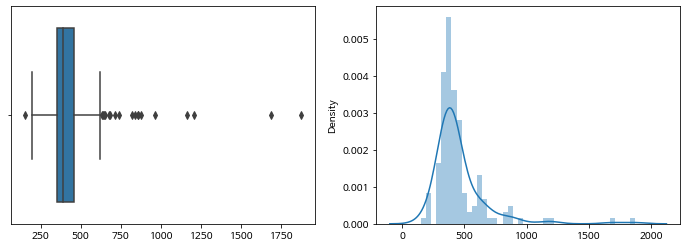

In [18]:
figure, (ax1, ax2) = plt.subplots(ncols=2)
figure.set_size_inches(12,4)

sns.boxplot(mean_values, ax=ax1)
sns.distplot(mean_values, ax=ax2)
plt.show()

In [19]:
pd.DataFrame(mean_values).describe()

0
count  148.000000
mean   457.691447
std    225.178756
min    150.591750
25%    351.710884
50%    393.107670
75%    460.451513
max   1872.878079

평균 버스정류장 간 거리는 **약 458m** 이므로 이를 constraint로 사용

### 3. Constraint 함수 생성

* 함수
1. 1순위 정류장과 다른 정류장 간의 거리 계산
2. 거리 < distance 인 정류장 제거
3. 위의 과정 num만큼 반복

In [20]:
# distance 이내의 정류장 제거하는 constraint
def constraint(data, distance, num):
    # 빈 데이터프레임
    df_result = pd.DataFrame(columns = data.columns)
    # 첫번째 정류장
    df_result.loc[0,:] = data.loc[np.argmin(data['rank']),:]
    data.drop(np.argmin(data['rank']), axis=0, inplace=True)
    data.reset_index(drop = True, inplace = True)
    
    for i in range(1, num):
        # distance 이내 정류장 제거
        drop_list = []
        station = tuple(df_result[['lon','lat']].iloc[i-1])
        for j in range(len(data)):
            candidate = tuple(data[['lon','lat']].iloc[j])
            if haversine(station, candidate, unit = 'm') < distance:
                drop_list.append(j)
        data.drop(drop_list, axis = 0, inplace = True)
        data.reset_index(drop = True, inplace = True)

        df_result.loc[i,:] = data.loc[np.argmin(data['rank']),:]
        data.drop(np.argmin(data['rank']), axis = 0, inplace = True)
        data.reset_index(drop = True, inplace = True)
    return df_result

## 2. 구별 설치위치

### 1. 팔달구

* 스마트 지수 순위

In [21]:
paldal['rank'] = paldal['smart'].rank(ascending = False, method = 'min')

In [22]:
paldal.sort_values(by = 'smart', ascending = False)

정류소ID                     정류장명        lon       lat         위치(동)  쉘터  LED  LCD  LED+LCD복합형  알뜰형  중앙차로여부  운행노선수  정류장유형수    초승_환승비율  초승_승차비율   초승_하차비율  환승_승차비율   환승_하차비율    승차_하차비율     승차비율     환승비율     하차비율    전체 승차 건수       초승 건수       환승 건수    전체 하차 건수  노선유형_경기순환버스(직행좌석형)  노선유형_광역급행형시내버스  노선유형_맞춤형시내버스  노선유형_일반형시내버스  노선유형_좌석형시내버스  노선유형_직행좌석형시내버스  승차많은버스  환승많은버스  하차많은버스  상행버스정류장운행시간  하행버스정류장운행시간  주중배차간격(분)   주중승차비율   주중환승비율   주중하차비율    주중전체승하차건수  주중배차간격_15분  주중배차간격_60분      주중배차횟수  주중승차많은버스  주중환승많은버스  주중하차많은버스    주중대기시간노출도  평균주중배차간격  주말배차간격(분)   주말승차비율   주말환승비율   주말하차비율    주말전체승하차건수  주말배차간격_15분  주말배차간격_60분      주말배차횟수  주말승차많은버스  주말환승많은버스  주말하차많은버스    주말대기시간노출도  평균주말배차간격  공휴일승차비율  공휴일환승비율  공휴일하차비율   공휴일전체승하차건수  공휴일승차많은버스  공휴일환승많은버스  공휴일하차많은버스   공휴일대기시간노출도   강수량상관관계    온도상관관계  미세먼지상관관계  미세먼지(㎍/㎥)  초미세먼지(㎍/㎥)  오존(ppm)  이산화질소(ppm)  아황산가스(ppm)  일산화탄소(ppm)  500m내지하철역갯수   지하철이용객      미세_봄     미세_여름     미세_가을     미세_겨울     초미세_봄    초미세_여름    초미세_가을    초미세_겨울  건축년도  전용면적(㎡)   층  \
6   202000106                수원역.AK플라자 127.000904 37.267365   경기도 수원시 매산동   1    1    0           0    0       0     31       2   0.890499 0.432717 23.376443 0.490359 32.098869  55.475312 0.269251 0.311261 0.419488 6284.094074 2735.369794 3548.724279 2604.190157                   0               0             0            22             4               0       0      19       4    19.666667    19.083333  62.153846 0.251140 0.331104 0.417756  9399.782393          11           8 1637.115926         0        19         4 76956.220902 60.000000  57.000000 0.339793 0.283397 0.376810  7818.235973           9           9 1273.682131         1        13         2 81279.589365 85.000000 0.345649 0.267717 0.386634  7572.999109          1         13          2 78968.399436 -0.021214  0.241145  0.120620  39.458333   23.125000 0.027917    0.024917    0.002958    0.562500            2  2260237 48.000000 29.833333 32.333333 47.666667 26.000000 16.333333 17.666667 32.500000  2014       15   4   
8   202000219                수원역.AK플라자 127.000934 37.267460   경기도 수원시 매산동   1    1    0           0    0       0     29       2   1.772688 0.463371  0.369718 0.536629  0.438927   0.808645 0.187903 0.223510 0.588587 7642.145160 3549.076860 4093.068300 8479.065431                   0               0             1            25             0               0       0      19       4    18.833333    19.250000  36.807692 0.177530 0.234918 0.587552 17468.609948          10           5 1658.499354         0        16         4 99707.856420 55.000000  47.326923 0.223430 0.195215 0.581355 13290.764358           7           7 1259.256477         0         4         4 99626.952520 90.000000 0.228244 0.182274 0.589481 12611.976307          0          2          4 95160.175654 -0.059249  0.201270  0.086535  39.458333   23.125000 0.027917    0.024917    0.002958    0.562500            2  2260237 48.000000 29.833333 32.333333 47.666667 26.000000 16.333333 17.666667 32.500000  2014       15   4   
2   202000019                   뉴코아아울렛 127.033552 37.265525   경기도 수원시 인계동   1    0    0           1    0       0     13       1  10.025648 0.892851 11.094018 0.107149  0.839893  11.933911 0.650190 0.073253 0.276557 1069.366255  945.032154  124.334100  703.821061                   0               0             0             7             0               3       4       0       0    19.000000    18.750000  22.350000 0.646934 0.074879 0.278187  1995.766599           4           0  741.822564         4         0         0 15233.944416 45.000000  30.350000 0.658259 0.068946 0.272795  1308.820638           3           2  531.029322         4         0         0 13708.313050 72.500000 0.671248 0.063567 0.265186  1123.288034          5          0          0 12020.916667 -0.050441  0.112289  0.063540  38.791667   24.000000 0.024750    0.027375    0.003000    0.629167            1  3576596 48.166667 25.000000 32.666667 49.333333 27.833333 16.666667 18.000000 33.500000  2014       15   9   
1   202000011               

In [23]:
print(sorted(paldal['rank'].unique()))

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0]


In [24]:
# Make layer
layer1 = pdk.Layer(
    'ScatterplotLayer',  
    paldal,
    get_position=['lon','lat'],
    pickable=True,
    auto_highlight=True,
    get_fill_color=[250, 0, 0],
    get_radius=100)

# 수원시 법정경계
geojson = pdk.Layer('GeoJsonLayer', 
                    df_29,
                    opacity = 0.1,
                    stroked = True,
                    filled = False,
                    extruded = False, 
                    wireframe = True,
                    lineWidthScale = 100,
                    get_line_color=[0, 0, 0]
                   )

# Set the viewport location 
center = [127.010465, 37.283850] 
view_state = pdk.ViewState( 
    longitude=center[0], 
    latitude=center[1], 
    zoom=11
) 

token = ?!
key = ?!


# Render 
r = pdk.Deck(layers= [geojson, layer1], initial_view_state=view_state, 
             mapbox_key = token, map_style='mapbox://styles/mapbox/dark-v10')        
r.to_html()

In [25]:
paldal_constraint = constraint(paldal, 458, 4*2)

In [26]:
paldal_constraint

정류소ID                     정류장명        lon       lat         위치(동) 쉘터 LED LCD LED+LCD복합형 알뜰형 중앙차로여부 운행노선수 정류장유형수   초승_환승비율  초승_승차비율   초승_하차비율  환승_승차비율   환승_하차비율   승차_하차비율     승차비율     환승비율     하차비율    전체 승차 건수       초승 건수       환승 건수    전체 하차 건수 노선유형_경기순환버스(직행좌석형) 노선유형_광역급행형시내버스 노선유형_맞춤형시내버스 노선유형_일반형시내버스 노선유형_좌석형시내버스 노선유형_직행좌석형시내버스 승차많은버스 환승많은버스 하차많은버스 상행버스정류장운행시간 하행버스정류장운행시간 주중배차간격(분)   주중승차비율   주중환승비율   주중하차비율   주중전체승하차건수 주중배차간격_15분 주중배차간격_60분      주중배차횟수 주중승차많은버스 주중환승많은버스 주중하차많은버스    주중대기시간노출도  평균주중배차간격 주말배차간격(분)   주말승차비율   주말환승비율   주말하차비율   주말전체승하차건수 주말배차간격_15분 주말배차간격_60분      주말배차횟수 주말승차많은버스 주말환승많은버스 주말하차많은버스    주말대기시간노출도  평균주말배차간격  공휴일승차비율  공휴일환승비율  공휴일하차비율  공휴일전체승하차건수 공휴일승차많은버스 공휴일환승많은버스 공휴일하차많은버스   공휴일대기시간노출도   강수량상관관계    온도상관관계 미세먼지상관관계 미세먼지(㎍/㎥) 초미세먼지(㎍/㎥)  오존(ppm) 이산화질소(ppm) 아황산가스(ppm) 일산화탄소(ppm) 500m내지하철역갯수   지하철이용객      미세_봄     미세_여름     미세_가을     미세_겨울     초미세_봄    초미세_여름    초미세_가을    초미세_겨울  건축년도 전용면적(㎡)   층   거래금액 면적당 금액 전체_추정교통량_전체시간 승용차_추정교통량_전체시간  \
0  202000106                수원역.AK플라자 127.000904 37.267365   경기도 수원시 매산동  1   1   0          0   0      0    31      2  0.890499 0.432717 23.376443 0.490359 32.098869 55.475312 0.269251 0.311261 0.419488 6284.094074 2735.369794 3548.724279 2604.190157                  0              0            0           22            4              0      0     19      4   19.666667   19.083333 62.153846 0.251140 0.331104 0.417756 9399.782393         11          8 1637.115926        0       19        4 76956.220902 60.000000 57.000000 0.339793 0.283397 0.376810 7818.235973          9          9 1273.682131        1       13        2 81279.589365 85.000000 0.345649 0.267717 0.386634 7572.999109         1        13         2 78968.399436 -0.021214  0.241145 0.120620 39.458333  23.125000 0.027917   0.024917   0.002958   0.562500           2  2260237 48.000000 29.833333 32.333333 47.666667 26.000000 16.333333 17.666667 32.500000  2014      15   4   7950    503   1523.080000    1244.800000   
1  202000019                   뉴코아아울렛 127.033552 37.265525   경기도 수원시 인계동  1   0   0          1   0      0    13      1 10.025648 0.892851 11.094018 0.107149  0.839893 11.933911 0.650190 0.073253 0.276557 1069.366255  945.032154  124.334100  703.821061                  0              0            0            7            0              3      4      0      0   19.000000   18.750000 22.350000 0.646934 0.074879 0.278187 1995.766599          4          0  741.822564        4        0        0 15233.944416 45.000000 30.350000 0.658259 0.068946 0.272795 1308.820638          3          2  531.029322        4        0        0 13708.313050 72.500000 0.671248 0.063567 0.265186 1123.288034         5         0         0 12020.916667 -0.050441  0.112289 0.063540 38.791667  24.000000 0.024750   0.027375   0.003000   0.629167           1  3576596 48.166667 25.000000 32.666667 49.333333 27.833333 16.666667 18.000000 33.500000  2014      15   9   7800    519   1575.224000    1323.068000   
2  202000231           팔달구청.화성행궁.수원성지 127.016262 37.283901   경기도 수원시 행궁동  1   0   0          1   0      0    26      1  1.470189 0.529838  0.424836 0.470162  0.459676  0.884512 0.198829 0.206672 0.594499 1015.191309  474.235692  540.955617 1473.790725                  0              0            0           23            0              1      0     12      4   19.033333   19.166667 44.979167 0.195573 0.213691 0.590736 2791.273600         13          2 1836.769406        0       10        4 13119.377312 55.000000 49.270833 0.214340 0.184245 0.601415 1838.076471          9          3 1442.008018        0        7        4 10427.512312 65.000000 0.219256 0.169599 0.611145 1879.833333         0         6         4 10633.250000 -0.044474  0.295585 0.016528 39.458333  23.125000 0.027917   0.024917   0.002958   0.562500           0  3954133 48.000000 29.833333 32.333333 47.666667 26.000000 16.333333 17.666667 32.500000  1990      82   2  12000    146    804.460000     697.440000   
3  202000045           KBS수원센터정문.한화생명 127.02849

* 시각화

In [27]:
paldal_constraint.isnull().sum().sort_values()

정류소ID         0
혼잡시간강도        0
유동인구_전체       0
유동인구_출퇴근      0
유동인구_출근       0
             ..
주말하차비율        0
주말전체승하차건수     0
주말배차간격_15분    0
주중대기시간노출도     0
rank          0
Length: 156, dtype: int64

In [28]:
paldal_plot = paldal_constraint.fillna(0)

In [29]:
paldal_plot.isnull().sum().sort_values()

정류소ID         0
혼잡시간강도        0
유동인구_전체       0
유동인구_출퇴근      0
유동인구_출근       0
             ..
주말하차비율        0
주말전체승하차건수     0
주말배차간격_15분    0
주중대기시간노출도     0
rank          0
Length: 156, dtype: int64

In [30]:
# Make layer
layer1 = pdk.Layer(
    'ScatterplotLayer',  
    paldal_plot,
    get_position=['lon','lat'],
    pickable=True,
    auto_highlight=True,
    get_fill_color=[250, 0, 0],
    get_radius=100)

# 수원시 법정경계
geojson = pdk.Layer('GeoJsonLayer', 
                    df_29,
                    opacity = 0.1,
                    stroked = True,
                    filled = False,
                    extruded = False, 
                    wireframe = True,
                    lineWidthScale = 100,
                    get_line_color=[0, 0, 0]
                   )

# Set the viewport location 
center = [127.010465, 37.283850] 
view_state = pdk.ViewState( 
    longitude=center[0], 
    latitude=center[1], 
    zoom=11
) 

token = ?!
key = ?!


# Render 
r = pdk.Deck(layers= [geojson, layer1], initial_view_state=view_state, 
             mapbox_key = token, map_style='mapbox://styles/mapbox/dark-v10')        
r.to_html()

### 2. 장안구

* 스마트 지수 순위

In [31]:
jangan['rank'] = jangan['smart'].rank(ascending = False, method = 'min')

In [32]:
jangan.sort_values(by = 'smart', ascending = False)

정류소ID                  정류장명        lon       lat         위치(동)  쉘터  LED  LCD  LED+LCD복합형  알뜰형  중앙차로여부  운행노선수  정류장유형수   초승_환승비율  초승_승차비율   초승_하차비율  환승_승차비율  환승_하차비율   승차_하차비율     승차비율     환승비율     하차비율    전체 승차 건수       초승 건수      환승 건수   전체 하차 건수  노선유형_경기순환버스(직행좌석형)  노선유형_광역급행형시내버스  노선유형_맞춤형시내버스  노선유형_일반형시내버스  노선유형_좌석형시내버스  노선유형_직행좌석형시내버스  승차많은버스  환승많은버스  하차많은버스  상행버스정류장운행시간  하행버스정류장운행시간  주중배차간격(분)   주중승차비율   주중환승비율   주중하차비율   주중전체승하차건수  주중배차간격_15분  주중배차간격_60분      주중배차횟수  주중승차많은버스  주중환승많은버스  주중하차많은버스    주중대기시간노출도  평균주중배차간격  주말배차간격(분)   주말승차비율   주말환승비율   주말하차비율   주말전체승하차건수  주말배차간격_15분  주말배차간격_60분      주말배차횟수  주말승차많은버스  주말환승많은버스  주말하차많은버스    주말대기시간노출도  평균주말배차간격  공휴일승차비율  공휴일환승비율  공휴일하차비율  공휴일전체승하차건수  공휴일승차많은버스  공휴일환승많은버스  공휴일하차많은버스   공휴일대기시간노출도   강수량상관관계    온도상관관계  미세먼지상관관계  미세먼지(㎍/㎥)  초미세먼지(㎍/㎥)  오존(ppm)  이산화질소(ppm)  아황산가스(ppm)  일산화탄소(ppm)  500m내지하철역갯수   지하철이용객  미세_봄     미세_여름     미세_가을     미세_겨울     초미세_봄    초미세_여름    초미세_가을    초미세_겨울  건축년도  전용면적(㎡)   층   거래금액  면적당 금액  \
28  202000053                우만동4단지 127.030921 37.292248   경기도 수원시 연무동   1    2    0           0    0       0     20       2  4.204869 0.749614  5.550912 0.250386 1.419879  6.970791 0.528313 0.150604 0.321084 1223.619161  933.250961 290.368201 779.196114                   0               0             0             8             0               8       7       3       0    18.833333    18.833333  28.625000 0.523611 0.156225 0.320163 2256.583742           4           1  857.534872         7         2         0 23722.512846 55.000000  35.968750 0.542112 0.131547 0.326341 1464.847057           0           3  640.227361         7         1         0 20145.348988 65.000000 0.530754 0.118115 0.351132 1270.408497          6          0          0 17130.230801 -0.033713  0.046382  0.076191  49.458333   24.166667 0.018250    0.034458    0.003042    0.704167            0  3954133    61 36.333333 39.666667 60.833333 28.333333 15.666667 17.166667 35.500000  1992       41  15  27400     663   
4   200000080        한일타운.경기일보.홈플러스 127.006636 37.303467  경기도 수원시 조원2동   1    0    0           3    0       0     21       3  4.296588 0.768741 10.157090 0.231259 2.372482 12.529572 0.441632 0.115612 0.442756 1922.177499 1615.897161 306.280338 901.334622                   1               0             0            10             1               3       4       2       0    19.000000    18.833333  64.233333 0.444513 0.117137 0.438350 3190.959740           6           2 1109.655412         4         0         0 23037.833724 55.000000  71.000000 0.429129 0.111956 0.458915 2050.161723           4           4  922.728053         4         0         0 17889.069654 70.000000 0.453091 0.111892 0.435017 1882.081197          4          1          0 16707.888889 -0.056355 -0.003161  0.136581  39.458333   23.125000 0.027917    0.024917    0.002958    0.562500            0  3954133    48 29.833333 32.333333 47.666667 26.000000 16.333333 17.666667 32.500000  1989       56   5  22500     400   
3   200000078                 수일중학교 126.999878 37.307095   경기도 수원시 파장동   1    0    0           1    0       0     15       1  4.793346 0.794794  8.782858 0.205206 1.892834 10.675693 0.304756 0.057414 0.637830  363.621431  317.870655  45.750776 321.404449                   0               0             0             8             1               3       3       1       6    18.833333    18.666667  72.666667 0.306761 0.056579 0.636660  776.801135           6           2  941.460034         3         0         6  3891.140312 42.500000  79.000000 0.297743 0.060767 0.641490  492.430123           3           3  794.004160         3         0         6  2892.874117 70.000000 0.295703 0.054836 0.649461  442.813725          3          1          7  2565.564542 -0.059694 -0.026404  0.108505  39.458333   23.125000 0.027917    0.024917    0.002958    0.562500            0  3954133    48 29.833333 32.333333 47.666667 26.000000 16.333333 17.666667 32.500000  1992       84   5  25000     294   
19  200000192       영화초등학교.한

In [33]:
print(sorted(jangan['rank'].unique()))

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0]


In [34]:
# Make layer
layer1 = pdk.Layer(
    'ScatterplotLayer',  
    jangan,
    get_position=['lon','lat'],
    pickable=True,
    auto_highlight=True,
    get_fill_color=[250, 0, 0],
    get_radius=100)

# 수원시 법정경계
geojson = pdk.Layer('GeoJsonLayer', 
                    df_29,
                    opacity = 0.1,
                    stroked = True,
                    filled = False,
                    extruded = False, 
                    wireframe = True,
                    lineWidthScale = 100,
                    get_line_color=[0, 0, 0]
                   )

# Set the viewport location 
center = [127.010465, 37.283850] 
view_state = pdk.ViewState( 
    longitude=center[0], 
    latitude=center[1], 
    zoom=11
) 

token = ?!
key = ?!


# Render 
r = pdk.Deck(layers= [geojson, layer1], initial_view_state=view_state, 
             mapbox_key = token, map_style='mapbox://styles/mapbox/dark-v10')        
r.to_html()

In [35]:
# 6의 2배수인 12개 추출해야하나 정류장 간 거리가 너무 가까워 추출가능한 최대갯수 추출
jangan_constraint = constraint(jangan, 458, 11)

In [36]:
jangan_constraint

정류소ID                  정류장명        lon       lat         위치(동) 쉘터 LED LCD LED+LCD복합형 알뜰형 중앙차로여부 운행노선수 정류장유형수   초승_환승비율  초승_승차비율   초승_하차비율  환승_승차비율  환승_하차비율   승차_하차비율     승차비율     환승비율     하차비율    전체 승차 건수       초승 건수      환승 건수   전체 하차 건수 노선유형_경기순환버스(직행좌석형) 노선유형_광역급행형시내버스 노선유형_맞춤형시내버스 노선유형_일반형시내버스 노선유형_좌석형시내버스 노선유형_직행좌석형시내버스 승차많은버스 환승많은버스 하차많은버스 상행버스정류장운행시간 하행버스정류장운행시간  주중배차간격(분)   주중승차비율   주중환승비율   주중하차비율   주중전체승하차건수 주중배차간격_15분 주중배차간격_60분      주중배차횟수 주중승차많은버스 주중환승많은버스 주중하차많은버스    주중대기시간노출도  평균주중배차간격  주말배차간격(분)   주말승차비율   주말환승비율   주말하차비율   주말전체승하차건수 주말배차간격_15분 주말배차간격_60분      주말배차횟수 주말승차많은버스 주말환승많은버스 주말하차많은버스    주말대기시간노출도  평균주말배차간격  공휴일승차비율  공휴일환승비율  공휴일하차비율  공휴일전체승하차건수 공휴일승차많은버스 공휴일환승많은버스 공휴일하차많은버스   공휴일대기시간노출도   강수량상관관계    온도상관관계 미세먼지상관관계 미세먼지(㎍/㎥) 초미세먼지(㎍/㎥)  오존(ppm) 이산화질소(ppm) 아황산가스(ppm) 일산화탄소(ppm) 500m내지하철역갯수   지하철이용객 미세_봄     미세_여름     미세_가을     미세_겨울     초미세_봄    초미세_여름    초미세_가을    초미세_겨울  건축년도 전용면적(㎡)   층   거래금액 면적당 금액 전체_추정교통량_전체시간 승용차_추정교통량_전체시간 버스_추정교통량_전체시간  \
0   202000053                우만동4단지 127.030921 37.292248   경기도 수원시 연무동  1   2   0          0   0      0    20      2  4.204869 0.749614  5.550912 0.250386 1.419879  6.970791 0.528313 0.150604 0.321084 1223.619161  933.250961 290.368201 779.196114                  0              0            0            8            0              8      7      3      0   18.833333   18.833333  28.625000 0.523611 0.156225 0.320163 2256.583742          4          1  857.534872        7        2        0 23722.512846 55.000000  35.968750 0.542112 0.131547 0.326341 1464.847057          0          3  640.227361        7        1        0 20145.348988 65.000000 0.530754 0.118115 0.351132 1270.408497         6         0         0 17130.230801 -0.033713  0.046382 0.076191 49.458333  24.166667 0.018250   0.034458   0.003042   0.704167           0  3954133   61 36.333333 39.666667 60.833333 28.333333 15.666667 17.166667 35.500000  1992      41  15  27400    663   2203.686667    1692.666667     35.546667   
1   200000080        한일타운.경기일보.홈플러스 127.006636 37.303467  경기도 수원시 조원2동  1   0   0          3   0      0    21      3  4.296588 0.768741 10.157090 0.231259 2.372482 12.529572 0.441632 0.115612 0.442756 1922.177499 1615.897161 306.280338 901.334622                  1              0            0           10            1              3      4      2      0   19.000000   18.833333  64.233333 0.444513 0.117137 0.438350 3190.959740          6          2 1109.655412        4        0        0 23037.833724 55.000000  71.000000 0.429129 0.111956 0.458915 2050.161723          4          4  922.728053        4        0        0 17889.069654 70.000000 0.453091 0.111892 0.435017 1882.081197         4         1         0 16707.888889 -0.056355 -0.003161 0.136581 39.458333  23.125000 0.027917   0.024917   0.002958   0.562500           0  3954133   48 29.833333 32.333333 47.666667 26.000000 16.333333 17.666667 32.500000  1989      56   5  22500    400   2170.230000    1759.000000     26.430000   
2   200000078                 수일중학교 126.999878 37.307095   경기도 수원시 파장동  1   0   0          1   0      0    15      1  4.793346 0.794794  8.782858 0.205206 1.892834 10.675693 0.304756 0.057414 0.637830  363.621431  317.870655  45.750776 321.404449                  0              0            0            8            1              3      3      1      6   18.833333   18.666667  72.666667 0.306761 0.056579 0.636660  776.801135          6          2  941.460034        3        0        6  3891.140312 42.500000  79.000000 0.297743 0.060767 0.641490  492.430123          3          3  794.004160        3        0        6  2892.874117 70.000000 0.295703 0.054836 0.649461  442.813725         3         1         7  2565.564542 -0.059694 -0.026404 0.108505 39.458333  23.125000 0.027917   0.024917   0.002958   0.562500           0  3954133   48 29.833333 32.333333 47.666667 26.000000 16.333333 17.666667 32.500000  1992      84   5  25000    294   2252.420000    1858.608571     28.082857   
3   200000192       영화초등

* 시각화

In [37]:
jangan_constraint.isnull().sum().sort_values()

정류소ID         0
혼잡시간강도        0
유동인구_전체       0
유동인구_출퇴근      0
유동인구_출근       0
             ..
주말하차비율        0
주말전체승하차건수     0
주말배차간격_15분    0
주중대기시간노출도     0
rank          0
Length: 156, dtype: int64

In [38]:
jangan_plot = jangan_constraint.fillna(0)

In [39]:
jangan_plot.isnull().sum().sort_values()

정류소ID         0
혼잡시간강도        0
유동인구_전체       0
유동인구_출퇴근      0
유동인구_출근       0
             ..
주말하차비율        0
주말전체승하차건수     0
주말배차간격_15분    0
주중대기시간노출도     0
rank          0
Length: 156, dtype: int64

In [40]:
# Make layer
layer1 = pdk.Layer(
    'ScatterplotLayer',  
    jangan_plot,
    get_position=['lon','lat'],
    pickable=True,
    auto_highlight=True,
    get_fill_color=[250, 0, 0],
    get_radius=100)

# 수원시 법정경계
geojson = pdk.Layer('GeoJsonLayer', 
                    df_29,
                    opacity = 0.1,
                    stroked = True,
                    filled = False,
                    extruded = False, 
                    wireframe = True,
                    lineWidthScale = 100,
                    get_line_color=[0, 0, 0]
                   )

# Set the viewport location 
center = [127.010465, 37.283850] 
view_state = pdk.ViewState( 
    longitude=center[0], 
    latitude=center[1], 
    zoom=11
) 

token = ?!
key = ?!


# Render 
r = pdk.Deck(layers= [geojson, layer1], initial_view_state=view_state, 
             mapbox_key = token, map_style='mapbox://styles/mapbox/dark-v10')        
r.to_html()

In [41]:
jangan_plot

정류소ID                  정류장명        lon       lat         위치(동)  쉘터  LED  LCD  LED+LCD복합형  알뜰형  중앙차로여부  운행노선수  정류장유형수   초승_환승비율  초승_승차비율   초승_하차비율  환승_승차비율  환승_하차비율   승차_하차비율     승차비율     환승비율     하차비율    전체 승차 건수       초승 건수      환승 건수   전체 하차 건수  노선유형_경기순환버스(직행좌석형)  노선유형_광역급행형시내버스  노선유형_맞춤형시내버스  노선유형_일반형시내버스  노선유형_좌석형시내버스  노선유형_직행좌석형시내버스  승차많은버스  환승많은버스  하차많은버스  상행버스정류장운행시간  하행버스정류장운행시간  주중배차간격(분)   주중승차비율   주중환승비율   주중하차비율   주중전체승하차건수  주중배차간격_15분  주중배차간격_60분      주중배차횟수  주중승차많은버스  주중환승많은버스  주중하차많은버스    주중대기시간노출도  평균주중배차간격  주말배차간격(분)   주말승차비율   주말환승비율   주말하차비율   주말전체승하차건수  주말배차간격_15분  주말배차간격_60분      주말배차횟수  주말승차많은버스  주말환승많은버스  주말하차많은버스    주말대기시간노출도  평균주말배차간격  공휴일승차비율  공휴일환승비율  공휴일하차비율  공휴일전체승하차건수  공휴일승차많은버스  공휴일환승많은버스  공휴일하차많은버스   공휴일대기시간노출도   강수량상관관계    온도상관관계  미세먼지상관관계  미세먼지(㎍/㎥)  초미세먼지(㎍/㎥)  오존(ppm)  이산화질소(ppm)  아황산가스(ppm)  일산화탄소(ppm)  500m내지하철역갯수   지하철이용객  미세_봄     미세_여름     미세_가을     미세_겨울     초미세_봄    초미세_여름    초미세_가을    초미세_겨울  건축년도  전용면적(㎡)   층   거래금액  면적당 금액  \
0   202000053                우만동4단지 127.030921 37.292248   경기도 수원시 연무동   1    2    0           0    0       0     20       2  4.204869 0.749614  5.550912 0.250386 1.419879  6.970791 0.528313 0.150604 0.321084 1223.619161  933.250961 290.368201 779.196114                   0               0             0             8             0               8       7       3       0    18.833333    18.833333  28.625000 0.523611 0.156225 0.320163 2256.583742           4           1  857.534872         7         2         0 23722.512846 55.000000  35.968750 0.542112 0.131547 0.326341 1464.847057           0           3  640.227361         7         1         0 20145.348988 65.000000 0.530754 0.118115 0.351132 1270.408497          6          0          0 17130.230801 -0.033713  0.046382  0.076191  49.458333   24.166667 0.018250    0.034458    0.003042    0.704167            0  3954133    61 36.333333 39.666667 60.833333 28.333333 15.666667 17.166667 35.500000  1992       41  15  27400     663   
1   200000080        한일타운.경기일보.홈플러스 127.006636 37.303467  경기도 수원시 조원2동   1    0    0           3    0       0     21       3  4.296588 0.768741 10.157090 0.231259 2.372482 12.529572 0.441632 0.115612 0.442756 1922.177499 1615.897161 306.280338 901.334622                   1               0             0            10             1               3       4       2       0    19.000000    18.833333  64.233333 0.444513 0.117137 0.438350 3190.959740           6           2 1109.655412         4         0         0 23037.833724 55.000000  71.000000 0.429129 0.111956 0.458915 2050.161723           4           4  922.728053         4         0         0 17889.069654 70.000000 0.453091 0.111892 0.435017 1882.081197          4          1          0 16707.888889 -0.056355 -0.003161  0.136581  39.458333   23.125000 0.027917    0.024917    0.002958    0.562500            0  3954133    48 29.833333 32.333333 47.666667 26.000000 16.333333 17.666667 32.500000  1989       56   5  22500     400   
2   200000078                 수일중학교 126.999878 37.307095   경기도 수원시 파장동   1    0    0           1    0       0     15       1  4.793346 0.794794  8.782858 0.205206 1.892834 10.675693 0.304756 0.057414 0.637830  363.621431  317.870655  45.750776 321.404449                   0               0             0             8             1               3       3       1       6    18.833333    18.666667  72.666667 0.306761 0.056579 0.636660  776.801135           6           2  941.460034         3         0         6  3891.140312 42.500000  79.000000 0.297743 0.060767 0.641490  492.430123           3           3  794.004160         3         0         6  2892.874117 70.000000 0.295703 0.054836 0.649461  442.813725          3          1          7  2565.564542 -0.059694 -0.026404  0.108505  39.458333   23.125000 0.027917    0.024917    0.002958    0.562500            0  3954133    48 29.833333 32.333333 47.666667 26.000000 16.333333 17.666667 32.500000  1992       84   5  25000     294   
3   200000192       영화초등학교.한

### 3. 영통구

* 스마트 지수 순위

In [42]:
yt['rank'] = yt['smart'].rank(ascending = False, method = 'min')

In [43]:
yt.sort_values(by = 'smart', ascending = False)

정류소ID                     정류장명        lon       lat         위치(동)  쉘터  LED  LCD  LED+LCD복합형  알뜰형  중앙차로여부  운행노선수  정류장유형수    초승_환승비율  초승_승차비율   초승_하차비율  환승_승차비율  환승_하차비율   승차_하차비율     승차비율     환승비율     하차비율    전체 승차 건수       초승 건수       환승 건수    전체 하차 건수  노선유형_경기순환버스(직행좌석형)  노선유형_광역급행형시내버스  노선유형_맞춤형시내버스  노선유형_일반형시내버스  노선유형_좌석형시내버스  노선유형_직행좌석형시내버스  승차많은버스  환승많은버스  하차많은버스  상행버스정류장운행시간  하행버스정류장운행시간  주중배차간격(분)   주중승차비율   주중환승비율   주중하차비율   주중전체승하차건수  주중배차간격_15분  주중배차간격_60분      주중배차횟수  주중승차많은버스  주중환승많은버스  주중하차많은버스    주중대기시간노출도  평균주중배차간격  주말배차간격(분)   주말승차비율   주말환승비율   주말하차비율   주말전체승하차건수  주말배차간격_15분  주말배차간격_60분      주말배차횟수  주말승차많은버스  주말환승많은버스  주말하차많은버스    주말대기시간노출도  평균주말배차간격  공휴일승차비율  공휴일환승비율  공휴일하차비율  공휴일전체승하차건수  공휴일승차많은버스  공휴일환승많은버스  공휴일하차많은버스   공휴일대기시간노출도   강수량상관관계    온도상관관계  미세먼지상관관계  미세먼지(㎍/㎥)  초미세먼지(㎍/㎥)  오존(ppm)  이산화질소(ppm)  아황산가스(ppm)  일산화탄소(ppm)  500m내지하철역갯수   지하철이용객      미세_봄     미세_여름     미세_가을     미세_겨울     초미세_봄    초미세_여름    초미세_가을    초미세_겨울  건축년도  전용면적(㎡)   층    거래금액  \
10  203000152  영통아이파크캐슬1단지.래미안영통마크원2단지 127.046286 37.245039   경기도 수원시 태장동   1    0    0           1    0       0     19       1  12.790132 0.917156 10.282627 0.082844 0.615020 10.897646 0.557599 0.048021 0.394379  407.306512  380.594106   26.712406  355.750879                   0               0             0            16             0               0       4       0       0    18.833333    19.000000  37.468750 0.559921 0.046367 0.393712  900.428235           7           3 1003.815056         4         0         0  7037.076884 55.000000  43.625000 0.548804 0.056286 0.394911  466.804469           6           7  780.907127         5         0         0  5173.383414 90.000000 0.533798 0.050784 0.415418  446.083333          6          0          1  4686.330065 -0.003727  0.078661  0.038113  40.291667   23.500000 0.027958    0.026833    0.002750    0.654167            0  3954133 49.000000 29.500000 33.166667 49.500000 26.166667 21.666667 18.333333 27.833333  2013       84  17   68000   
11  203000174               원천레이크파크아파트 127.062484 37.269424   경기도 수원시 원천동   1    1    0           0    0       0     25       1   4.707137 0.716408  6.993187 0.283592 1.830320  8.823507 0.272233 0.126368 0.601399  317.183543  224.212054   92.971489  616.617742                   0               0             0            17             0               4       2       3       3    18.866667    19.166667  29.976190 0.272318 0.125812 0.601871 1093.668054           6           2 1180.285540         2         3         3  7062.811258 55.000000  35.714286 0.269967 0.131146 0.598887  597.080903           4           2  905.627911         2         3         3  4675.996936 60.000000 0.279079 0.123052 0.597869  521.138238          2          3          2  4297.683886 -0.030145  0.060094  0.048588  40.291667   23.500000 0.027958    0.026833    0.002750    0.654167            0  3954133 49.000000 29.500000 33.166667 49.500000 26.166667 21.666667 18.333333 27.833333  1999       59   1   29000   
14  203000071          광교호수공원입구.원천교사거리 127.059640 37.270955   경기도 수원시 원천동   1    0    1           0    0       0     23       2  12.478173 0.906066 11.067754 0.093934 0.761129 11.828883 0.574118 0.056134 0.369748  363.541477  331.576993   31.964484  227.097513                   0               2             0            15             0               2       6       0       0    18.866667    19.166667  30.105263 0.578708 0.054544 0.366748  668.731099           7           2 1120.754985         6         0         0  6613.162493 55.000000  34.921053 0.558459 0.062929 0.378611  425.334645           5           2  896.459729         6         0         0  5029.029421 60.000000 0.550934 0.074003 0.375063  373.698413          6          1          0  4484.476190 -0.023547  0.273113 -0.036855  40.291667   23.500000 0.027958    0.026833    0.002750    0.654167            0  3954133 49.000000 29.500000 33.166667 49.500000 26.166667 21.666667 18.333333 27.833333  1999       59   1   29000   
27  203000046   

In [44]:
print(sorted(yt['rank'].unique()))

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0]


In [45]:
# Make layer
layer1 = pdk.Layer(
    'ScatterplotLayer',  
    yt,
    get_position=['lon','lat'],
    pickable=True,
    auto_highlight=True,
    get_fill_color=[250, 0, 0],
    get_radius=100)

# 수원시 법정경계
geojson = pdk.Layer('GeoJsonLayer', 
                    df_29,
                    opacity = 0.1,
                    stroked = True,
                    filled = False,
                    extruded = False, 
                    wireframe = True,
                    lineWidthScale = 100,
                    get_line_color=[0, 0, 0]
                   )

# Set the viewport location 
center = [127.010465, 37.283850] 
view_state = pdk.ViewState( 
    longitude=center[0], 
    latitude=center[1], 
    zoom=11
) 

token = ?!
key = ?!


# Render 
r = pdk.Deck(layers= [geojson, layer1], initial_view_state=view_state, 
             mapbox_key = token, map_style='mapbox://styles/mapbox/dark-v10')        
r.to_html()

In [46]:
# 9의 2배수인 18개 추출해야하나 정류장 간 거리가 너무 가까워 추출가능한 최대갯수 추출
yt_constraint = constraint(yt, 458, 13)

In [47]:
yt_constraint

정류소ID                     정류장명        lon       lat         위치(동) 쉘터 LED LCD LED+LCD복합형 알뜰형 중앙차로여부 운행노선수 정류장유형수    초승_환승비율  초승_승차비율   초승_하차비율  환승_승차비율  환승_하차비율   승차_하차비율     승차비율     환승비율     하차비율    전체 승차 건수       초승 건수       환승 건수    전체 하차 건수 노선유형_경기순환버스(직행좌석형) 노선유형_광역급행형시내버스 노선유형_맞춤형시내버스 노선유형_일반형시내버스 노선유형_좌석형시내버스 노선유형_직행좌석형시내버스 승차많은버스 환승많은버스 하차많은버스 상행버스정류장운행시간 하행버스정류장운행시간 주중배차간격(분)   주중승차비율   주중환승비율   주중하차비율   주중전체승하차건수 주중배차간격_15분 주중배차간격_60분      주중배차횟수 주중승차많은버스 주중환승많은버스 주중하차많은버스    주중대기시간노출도  평균주중배차간격 주말배차간격(분)   주말승차비율   주말환승비율   주말하차비율   주말전체승하차건수 주말배차간격_15분 주말배차간격_60분      주말배차횟수 주말승차많은버스 주말환승많은버스 주말하차많은버스    주말대기시간노출도  평균주말배차간격  공휴일승차비율  공휴일환승비율  공휴일하차비율  공휴일전체승하차건수 공휴일승차많은버스 공휴일환승많은버스 공휴일하차많은버스   공휴일대기시간노출도   강수량상관관계    온도상관관계  미세먼지상관관계 미세먼지(㎍/㎥) 초미세먼지(㎍/㎥)  오존(ppm) 이산화질소(ppm) 아황산가스(ppm) 일산화탄소(ppm) 500m내지하철역갯수   지하철이용객      미세_봄     미세_여름     미세_가을     미세_겨울     초미세_봄    초미세_여름    초미세_가을    초미세_겨울  건축년도 전용면적(㎡)   층    거래금액 면적당 금액 전체_추정교통량_전체시간 승용차_추정교통량_전체시간  \
0   203000152  영통아이파크캐슬1단지.래미안영통마크원2단지 127.046286 37.245039   경기도 수원시 태장동  1   0   0          1   0      0    19      1  12.790132 0.917156 10.282627 0.082844 0.615020 10.897646 0.557599 0.048021 0.394379  407.306512  380.594106   26.712406  355.750879                  0              0            0           16            0              0      4      0      0   18.833333   19.000000 37.468750 0.559921 0.046367 0.393712  900.428235          7          3 1003.815056        4        0        0  7037.076884 55.000000 43.625000 0.548804 0.056286 0.394911  466.804469          6          7  780.907127        5        0        0  5173.383414 90.000000 0.533798 0.050784 0.415418  446.083333         6         0         1  4686.330065 -0.003727  0.078661  0.038113 40.291667  23.500000 0.027958   0.026833   0.002750   0.654167           0  3954133 49.000000 29.500000 33.166667 49.500000 26.166667 21.666667 18.333333 27.833333  2013      84  17   68000    800   2132.556000    1720.400000   
1   203000174               원천레이크파크아파트 127.062484 37.269424   경기도 수원시 원천동  1   1   0          0   0      0    25      1   4.707137 0.716408  6.993187 0.283592 1.830320  8.823507 0.272233 0.126368 0.601399  317.183543  224.212054   92.971489  616.617742                  0              0            0           17            0              4      2      3      3   18.866667   19.166667 29.976190 0.272318 0.125812 0.601871 1093.668054          6          2 1180.285540        2        3        3  7062.811258 55.000000 35.714286 0.269967 0.131146 0.598887  597.080903          4          2  905.627911        2        3        3  4675.996936 60.000000 0.279079 0.123052 0.597869  521.138238         2         3         2  4297.683886 -0.030145  0.060094  0.048588 40.291667  23.500000 0.027958   0.026833   0.002750   0.654167           0  3954133 49.000000 29.500000 33.166667 49.500000 26.166667 21.666667 18.333333 27.833333  1999      59   1   29000    483   2105.254286    1728.905714   
2   203000046           수원광교박물관.광교카페거리 127.051198 37.294768  경기도 수원시 광교1동  1   0   1          0   0      0     7      3   4.174918 0.789747  3.760648 0.210253 0.514067  4.274714 0.314129 0.070170 0.615700   75.679508   57.932661   17.746847  179.590719                  0              0            0            5            0              1      1      0      1   18.166667   18.500000 24.583333 0.323979 0.075796 0.600225  278.443927          3          0  378.714706        1        0        1  1249.665794 50.000000 35.500000 0.265602 0.050885 0.683512  207.125447          0          2  243.651160        1        0        3   969.280269 65.000000 0.271824 0.055596 0.672580  169.512605         1         0         3   865.504202 -0.107337  0.022703  0.104282 40.875000  21.416667 0.024625   0.029375   0.003167   0.541667           1  3954133 47.833333 33.000000 34.833333 47.833333 26.000000 16.166667 15.333333 28.166667  2015     107  11  150000   1396   2914.168571    2338.022857   
3   203000122                  청명역3번

* 시각화

In [48]:
yt_constraint.isnull().sum().sort_values()

정류소ID         0
혼잡빈도강도        0
혼잡시간강도        0
유동인구_전체       0
유동인구_출퇴근      0
             ..
주말하차비율        0
주말전체승하차건수     0
주말배차간격_15분    0
주중대기시간노출도     0
rank          0
Length: 155, dtype: int64

In [49]:
yt_plot = yt_constraint.fillna(0)

In [50]:
yt_plot.isnull().sum().sort_values()

정류소ID         0
혼잡빈도강도        0
혼잡시간강도        0
유동인구_전체       0
유동인구_출퇴근      0
             ..
주말하차비율        0
주말전체승하차건수     0
주말배차간격_15분    0
주중대기시간노출도     0
rank          0
Length: 155, dtype: int64

In [51]:
# Make layer
layer1 = pdk.Layer(
    'ScatterplotLayer',  
    yt_plot,
    get_position=['lon','lat'],
    pickable=True,
    auto_highlight=True,
    get_fill_color=[250, 0, 0],
    get_radius=100)

# 수원시 법정경계
geojson = pdk.Layer('GeoJsonLayer', 
                    df_29,
                    opacity = 0.1,
                    stroked = True,
                    filled = False,
                    extruded = False, 
                    wireframe = True,
                    lineWidthScale = 100,
                    get_line_color=[0, 0, 0]
                   )

# Set the viewport location 
center = [127.010465, 37.283850] 
view_state = pdk.ViewState( 
    longitude=center[0], 
    latitude=center[1], 
    zoom=11
) 

token = ?!
key = ?!


# Render 
r = pdk.Deck(layers= [geojson, layer1], initial_view_state=view_state, 
             mapbox_key = token, map_style='mapbox://styles/mapbox/dark-v10')        
r.to_html()

In [52]:
yt_plot

정류소ID                     정류장명        lon       lat         위치(동)  쉘터  LED  LCD  LED+LCD복합형  알뜰형  중앙차로여부  운행노선수  정류장유형수    초승_환승비율  초승_승차비율   초승_하차비율  환승_승차비율  환승_하차비율   승차_하차비율     승차비율     환승비율     하차비율    전체 승차 건수       초승 건수       환승 건수    전체 하차 건수  노선유형_경기순환버스(직행좌석형)  노선유형_광역급행형시내버스  노선유형_맞춤형시내버스  노선유형_일반형시내버스  노선유형_좌석형시내버스  노선유형_직행좌석형시내버스  승차많은버스  환승많은버스  하차많은버스  상행버스정류장운행시간  하행버스정류장운행시간  주중배차간격(분)   주중승차비율   주중환승비율   주중하차비율   주중전체승하차건수  주중배차간격_15분  주중배차간격_60분      주중배차횟수  주중승차많은버스  주중환승많은버스  주중하차많은버스    주중대기시간노출도  평균주중배차간격  주말배차간격(분)   주말승차비율   주말환승비율   주말하차비율   주말전체승하차건수  주말배차간격_15분  주말배차간격_60분      주말배차횟수  주말승차많은버스  주말환승많은버스  주말하차많은버스    주말대기시간노출도  평균주말배차간격  공휴일승차비율  공휴일환승비율  공휴일하차비율  공휴일전체승하차건수  공휴일승차많은버스  공휴일환승많은버스  공휴일하차많은버스   공휴일대기시간노출도   강수량상관관계    온도상관관계  미세먼지상관관계  미세먼지(㎍/㎥)  초미세먼지(㎍/㎥)  오존(ppm)  이산화질소(ppm)  아황산가스(ppm)  일산화탄소(ppm)  500m내지하철역갯수   지하철이용객      미세_봄     미세_여름     미세_가을     미세_겨울     초미세_봄    초미세_여름    초미세_가을    초미세_겨울  건축년도  전용면적(㎡)   층    거래금액  \
0   203000152  영통아이파크캐슬1단지.래미안영통마크원2단지 127.046286 37.245039   경기도 수원시 태장동   1    0    0           1    0       0     19       1  12.790132 0.917156 10.282627 0.082844 0.615020 10.897646 0.557599 0.048021 0.394379  407.306512  380.594106   26.712406  355.750879                   0               0             0            16             0               0       4       0       0    18.833333    19.000000  37.468750 0.559921 0.046367 0.393712  900.428235           7           3 1003.815056         4         0         0  7037.076884 55.000000  43.625000 0.548804 0.056286 0.394911  466.804469           6           7  780.907127         5         0         0  5173.383414 90.000000 0.533798 0.050784 0.415418  446.083333          6          0          1  4686.330065 -0.003727  0.078661  0.038113  40.291667   23.500000 0.027958    0.026833    0.002750    0.654167            0  3954133 49.000000 29.500000 33.166667 49.500000 26.166667 21.666667 18.333333 27.833333  2013       84  17   68000   
1   203000174               원천레이크파크아파트 127.062484 37.269424   경기도 수원시 원천동   1    1    0           0    0       0     25       1   4.707137 0.716408  6.993187 0.283592 1.830320  8.823507 0.272233 0.126368 0.601399  317.183543  224.212054   92.971489  616.617742                   0               0             0            17             0               4       2       3       3    18.866667    19.166667  29.976190 0.272318 0.125812 0.601871 1093.668054           6           2 1180.285540         2         3         3  7062.811258 55.000000  35.714286 0.269967 0.131146 0.598887  597.080903           4           2  905.627911         2         3         3  4675.996936 60.000000 0.279079 0.123052 0.597869  521.138238          2          3          2  4297.683886 -0.030145  0.060094  0.048588  40.291667   23.500000 0.027958    0.026833    0.002750    0.654167            0  3954133 49.000000 29.500000 33.166667 49.500000 26.166667 21.666667 18.333333 27.833333  1999       59   1   29000   
2   203000046           수원광교박물관.광교카페거리 127.051198 37.294768  경기도 수원시 광교1동   1    0    1           0    0       0      7       3   4.174918 0.789747  3.760648 0.210253 0.514067  4.274714 0.314129 0.070170 0.615700   75.679508   57.932661   17.746847  179.590719                   0               0             0             5             0               1       1       0       1    18.166667    18.500000  24.583333 0.323979 0.075796 0.600225  278.443927           3           0  378.714706         1         0         1  1249.665794 50.000000  35.500000 0.265602 0.050885 0.683512  207.125447           0           2  243.651160         1         0         3   969.280269 65.000000 0.271824 0.055596 0.672580  169.512605          1          0          3   865.504202 -0.107337  0.022703  0.104282  40.875000   21.416667 0.024625    0.029375    0.003167    0.541667            1  3954133 47.833333 33.000000 34.833333 47.833333 26.000000 16.166667 15.333333 28.166667  2015      107  11  150000   
3   203000122   

### 4. 권선구

* 스마트 지수 순위

In [53]:
gs['rank'] = gs['smart'].rank(ascending = False, method = 'min')

In [54]:
gs.sort_values(by = 'smart', ascending = False)

정류소ID                정류장명        lon       lat         위치(동)  쉘터  LED  LCD  LED+LCD복합형  알뜰형  중앙차로여부  운행노선수  정류장유형수   초승_환승비율  초승_승차비율    초승_하차비율  환승_승차비율   환승_하차비율    승차_하차비율     승차비율     환승비율     하차비율    전체 승차 건수      초승 건수      환승 건수    전체 하차 건수  노선유형_경기순환버스(직행좌석형)  노선유형_광역급행형시내버스  노선유형_맞춤형시내버스  노선유형_일반형시내버스  노선유형_좌석형시내버스  노선유형_직행좌석형시내버스     전체승하차건수  승차많은버스  환승많은버스  하차많은버스  상행버스정류장운행시간  하행버스정류장운행시간  주중배차간격(분)   주중승차비율   주중환승비율   주중하차비율   주중전체승하차건수  주중배차간격_15분  주중배차간격_60분      주중배차횟수  주중승차많은버스  주중환승많은버스  주중하차많은버스    주중대기시간노출도  평균주중배차간격  주말배차간격(분)   주말승차비율   주말환승비율   주말하차비율   주말전체승하차건수  주말배차간격_15분  주말배차간격_60분     주말배차횟수  주말승차많은버스  주말환승많은버스  주말하차많은버스    주말대기시간노출도  평균주말배차간격  공휴일승차비율  공휴일환승비율  공휴일하차비율  공휴일전체승하차건수  공휴일승차많은버스  공휴일환승많은버스  공휴일하차많은버스   공휴일대기시간노출도   강수량상관관계    온도상관관계  미세먼지상관관계  미세먼지(㎍/㎥)  초미세먼지(㎍/㎥)  오존(ppm)  이산화질소(ppm)  아황산가스(ppm)  일산화탄소(ppm)  500m내지하철역갯수   지하철이용객      미세_봄     미세_여름     미세_가을     미세_겨울     초미세_봄    초미세_여름    초미세_가을    초미세_겨울  건축년도  전용면적(㎡)   층  \
3   201000197             수원버스터미널 127.019716 37.249796  경기도 수원시 권선2동   1    1    0           0    0       0     17       1  7.939600 0.873904   1.311661 0.126096  0.175284   1.486944 0.499731 0.068561 0.431708  927.157994 823.471929 103.686065  564.380161                   0               0             0            13             0               1 1491.538155       0       0       1    18.833333    19.083333  30.107143 0.476542 0.073013 0.450445 1475.701200           7           2  953.099964         0         0         1 11942.751538 55.000000  36.428571 0.547976 0.058473 0.393551 1514.749038           4           5 702.529883         1         0         1 19122.737179 65.000000 0.540728 0.051255 0.408017 1603.974359          1          0          1 20025.263889 -0.059786  0.089524  0.139768  38.791667   24.000000 0.024750    0.027375    0.003000    0.629167            0  3954133 48.166667 25.000000 32.666667 49.333333 27.833333 16.666667 18.000000 33.500000  1994       49  11   
25  201000192             수원버스터미널 127.021675 37.248946  경기도 수원시 권선2동   1    1    0           0    0       0     19       2  5.898940 0.827313  34.062767 0.172687  3.644885  37.707652 0.458781 0.088660 0.452559 1217.860878 995.483278 222.377600 1430.715206                   0               0             0            14             0               3 2648.576083       3       0       0    19.166667    19.083333  25.617647 0.458417 0.091247 0.450336 2886.619126           9           2 1251.025734         3         0         0 19285.187702 55.000000  30.294118 0.461871 0.082291 0.455838 2131.915064           5           4 940.524240         3         0         0 17816.455128 65.000000 0.460944 0.083423 0.455633 2128.486111          3          0          0 17546.250000 -0.056786  0.096853  0.081163  38.791667   24.000000 0.024750    0.027375    0.003000    0.629167            0  3954133 48.166667 25.000000 32.666667 49.333333 27.833333 16.666667 18.000000 33.500000  1994       49  11   
4   201000200              곡반초등학교 127.036666 37.245990   경기도 수원시 곡선동   1    0    0           1    0       0     14       1 26.940952 0.896302   0.405786 0.103698  0.013284   0.419069 0.356856 0.083217 0.559927  266.061736 257.478934   8.582802  478.834395                   0               0             0            10             0               2  744.896131       1       1       1    19.333333    19.000000  36.666667 0.342885 0.078517 0.578598  862.975379           4           2  649.337700         1         1         1  4118.487560 55.000000  41.083333 0.409132 0.101400 0.489468  496.155037           3           5 517.492062         1         1         0  4166.995085 65.000000 0.434717 0.011148 0.554134  417.347222          1          0          2  3379.805556 -0.036301  0.082609  0.043160  38.791667   24.000000 0.024750    0.027375    0.003000    0.629167            0  3954133 48.166667 25.000000 32.666667 49.333333 27.833333 16.666667 18.000000 33.500000  2001      125   9   
28  201000198           

In [55]:
print(sorted(gs['rank'].unique()))

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0]


In [56]:
# Make layer
layer1 = pdk.Layer(
    'ScatterplotLayer',  
    gs,
    get_position=['lon','lat'],
    pickable=True,
    auto_highlight=True,
    get_fill_color=[250, 0, 0],
    get_radius=100)

# 수원시 법정경계
geojson = pdk.Layer('GeoJsonLayer', 
                    df_29,
                    opacity = 0.1,
                    stroked = True,
                    filled = False,
                    extruded = False, 
                    wireframe = True,
                    lineWidthScale = 100,
                    get_line_color=[0, 0, 0]
                   )

# Set the viewport location 
center = [127.010465, 37.283850] 
view_state = pdk.ViewState( 
    longitude=center[0], 
    latitude=center[1], 
    zoom=11
) 

token = ?!
key = ?!


# Render 
r = pdk.Deck(layers= [geojson, layer1], initial_view_state=view_state, 
             mapbox_key = token, map_style='mapbox://styles/mapbox/dark-v10')        
r.to_html()

In [57]:
# 11의 2배수인 22개 추출해야하나 정류장 간 거리가 너무 가까워 추출가능한 최대갯수 추출
gs_constraint = constraint(gs, 458, 19)

In [58]:
gs_constraint

정류소ID                정류장명        lon       lat         위치(동) 쉘터 LED LCD LED+LCD복합형 알뜰형 중앙차로여부 운행노선수 정류장유형수   초승_환승비율  초승_승차비율    초승_하차비율  환승_승차비율  환승_하차비율    승차_하차비율     승차비율     환승비율     하차비율   전체 승차 건수      초승 건수      환승 건수    전체 하차 건수 노선유형_경기순환버스(직행좌석형) 노선유형_광역급행형시내버스 노선유형_맞춤형시내버스 노선유형_일반형시내버스 노선유형_좌석형시내버스 노선유형_직행좌석형시내버스     전체승하차건수 승차많은버스 환승많은버스 하차많은버스 상행버스정류장운행시간 하행버스정류장운행시간  주중배차간격(분)   주중승차비율   주중환승비율   주중하차비율   주중전체승하차건수 주중배차간격_15분 주중배차간격_60분      주중배차횟수 주중승차많은버스 주중환승많은버스 주중하차많은버스    주중대기시간노출도  평균주중배차간격  주말배차간격(분)   주말승차비율   주말환승비율   주말하차비율   주말전체승하차건수 주말배차간격_15분 주말배차간격_60분     주말배차횟수 주말승차많은버스 주말환승많은버스 주말하차많은버스    주말대기시간노출도  평균주말배차간격  공휴일승차비율  공휴일환승비율  공휴일하차비율  공휴일전체승하차건수 공휴일승차많은버스 공휴일환승많은버스 공휴일하차많은버스   공휴일대기시간노출도   강수량상관관계    온도상관관계  미세먼지상관관계 미세먼지(㎍/㎥) 초미세먼지(㎍/㎥)  오존(ppm) 이산화질소(ppm) 아황산가스(ppm) 일산화탄소(ppm) 500m내지하철역갯수   지하철이용객      미세_봄     미세_여름     미세_가을     미세_겨울     초미세_봄    초미세_여름    초미세_가을    초미세_겨울  건축년도 전용면적(㎡)   층   거래금액 면적당 금액 전체_추정교통량_전체시간 승용차_추정교통량_전체시간  \
0   201000197             수원버스터미널 127.019716 37.249796  경기도 수원시 권선2동  1   1   0          0   0      0    17      1  7.939600 0.873904   1.311661 0.126096 0.175284   1.486944 0.499731 0.068561 0.431708 927.157994 823.471929 103.686065  564.380161                  0              0            0           13            0              1 1491.538155      0      0      1   18.833333   19.083333  30.107143 0.476542 0.073013 0.450445 1475.701200          7          2  953.099964        0        0        1 11942.751538 55.000000  36.428571 0.547976 0.058473 0.393551 1514.749038          4          5 702.529883        1        0        1 19122.737179 65.000000 0.540728 0.051255 0.408017 1603.974359         1         0         1 20025.263889 -0.059786  0.089524  0.139768 38.791667  24.000000 0.024750   0.027375   0.003000   0.629167           0  3954133 48.166667 25.000000 32.666667 49.333333 27.833333 16.666667 18.000000 33.500000  1994      49  11  18000    364   2835.640000    2330.660000   
1   201000200              곡반초등학교 127.036666 37.245990   경기도 수원시 곡선동  1   0   0          1   0      0    14      1 26.940952 0.896302   0.405786 0.103698 0.013284   0.419069 0.356856 0.083217 0.559927 266.061736 257.478934   8.582802  478.834395                  0              0            0           10            0              2  744.896131      1      1      1   19.333333   19.000000  36.666667 0.342885 0.078517 0.578598  862.975379          4          2  649.337700        1        1        1  4118.487560 55.000000  41.083333 0.409132 0.101400 0.489468  496.155037          3          5 517.492062        1        1        0  4166.995085 65.000000 0.434717 0.011148 0.554134  417.347222         1         0         2  3379.805556 -0.036301  0.082609  0.043160 38.791667  24.000000 0.024750   0.027375   0.003000   0.629167           0  3954133 48.166667 25.000000 32.666667 49.333333 27.833333 16.666667 18.000000 33.500000  2001     125   9  53000    421   2922.185000    2398.540000   
2   201000023      고색역.고색초교.태산아파트 126.979930 37.250431    경기도 수원시 평동  1   1   0          0   0      0    33      3  5.755202 0.826671   2.824972 0.173329 0.740922   3.565893 0.463279 0.091232 0.445489 809.386900 686.066921 123.319978  446.915572                  0              0            0           23            2              5 1256.302472      3      2      5   18.500000   18.833333 111.550000 0.449018 0.092756 0.458227 1461.035239          5         16  896.252956        3        2        5 19997.450902 60.000000 119.916667 0.509618 0.085212 0.405170  823.825276          2         18 712.173511        7        0        5 17573.532107 90.000000 0.531437 0.079581 0.388982  757.545904         8         1         4 17169.202614 -0.081422  0.014562  0.164225 39.625000  22.208333 0.023167   0.026667   0.002833   0.583333           1  3954133 43.000000 31.333333 35.333333 48.833333 24.666667 14.166667 17.000000 33.000000  1998      59   5  27800    464   1473.616667    1227.520000   
3   201000430   

* 확인

In [59]:
gs_constraint.isnull().sum().sort_values()

정류소ID        0
혼잡빈도강도       0
혼잡시간강도       0
유동인구_전체      0
유동인구_출퇴근     0
            ..
주말환승비율       0
주말하차비율       0
주말전체승하차건수    0
주중하차많은버스     0
rank         0
Length: 156, dtype: int64

In [60]:
gs_plot = gs_constraint.fillna(0)

In [61]:
gs_plot.isnull().sum().sort_values()

정류소ID        0
혼잡빈도강도       0
혼잡시간강도       0
유동인구_전체      0
유동인구_출퇴근     0
            ..
주말환승비율       0
주말하차비율       0
주말전체승하차건수    0
주중하차많은버스     0
rank         0
Length: 156, dtype: int64

In [62]:
# Make layer
layer1 = pdk.Layer(
    'ScatterplotLayer',  
    gs_plot,
    get_position=['lon','lat'],
    pickable=True,
    auto_highlight=True,
    get_fill_color=[250, 0, 0],
    get_radius=100)

# 수원시 법정경계
geojson = pdk.Layer('GeoJsonLayer', 
                    df_29,
                    opacity = 0.1,
                    stroked = True,
                    filled = False,
                    extruded = False, 
                    wireframe = True,
                    lineWidthScale = 100,
                    get_line_color=[0, 0, 0]
                   )

# Set the viewport location 
center = [127.010465, 37.283850] 
view_state = pdk.ViewState( 
    longitude=center[0], 
    latitude=center[1], 
    zoom=11
) 

token = ?!
key = ?!


# Render 
r = pdk.Deck(layers= [geojson, layer1], initial_view_state=view_state, 
             mapbox_key = token, map_style='mapbox://styles/mapbox/dark-v10')        
r.to_html()

## 3. 최종 결과

### 1. 설치 순위

* 데이터 통합

In [63]:
df_plot = pd.concat([paldal_plot, jangan_plot, yt_plot, gs_plot], axis = 0)
df_result = df_plot.reset_index(drop = True)

In [64]:
df_result.shape

(51, 156)

In [65]:
# Make layer
layer1 = pdk.Layer(
    'ScatterplotLayer',  
    df_result,
    get_position=['lon','lat'],
    pickable=True,
    auto_highlight=True,
    get_fill_color=[250, 0, 0],
    get_radius=100)

# 수원시 법정경계
geojson = pdk.Layer('GeoJsonLayer', 
                    df_29,
                    opacity = 0.1,
                    stroked = True,
                    filled = False,
                    extruded = False, 
                    wireframe = True,
                    lineWidthScale = 100,
                    get_line_color=[0, 0, 0]
                   )

# Set the viewport location 
center = [127.010465, 37.283850] 
view_state = pdk.ViewState( 
    longitude=center[0], 
    latitude=center[1], 
    zoom=11
) 

token = ?!
key = ?!


# Render 
r = pdk.Deck(layers= [geojson, layer1], initial_view_state=view_state, 
             mapbox_key = token, map_style='mapbox://styles/mapbox/dark-v10')        
r.to_html()

In [66]:
df_result.head(2)

정류소ID       정류장명        lon       lat        위치(동)  쉘터  LED  LCD  LED+LCD복합형  알뜰형  중앙차로여부  운행노선수  정류장유형수   초승_환승비율  초승_승차비율   초승_하차비율  환승_승차비율   환승_하차비율   승차_하차비율     승차비율     환승비율     하차비율    전체 승차 건수       초승 건수       환승 건수    전체 하차 건수  노선유형_경기순환버스(직행좌석형)  노선유형_광역급행형시내버스  노선유형_맞춤형시내버스  노선유형_일반형시내버스  노선유형_좌석형시내버스  노선유형_직행좌석형시내버스  승차많은버스  환승많은버스  하차많은버스  상행버스정류장운행시간  하행버스정류장운행시간  주중배차간격(분)   주중승차비율   주중환승비율   주중하차비율   주중전체승하차건수  주중배차간격_15분  주중배차간격_60분      주중배차횟수  주중승차많은버스  주중환승많은버스  주중하차많은버스    주중대기시간노출도  평균주중배차간격  주말배차간격(분)   주말승차비율   주말환승비율   주말하차비율   주말전체승하차건수  주말배차간격_15분  주말배차간격_60분      주말배차횟수  주말승차많은버스  주말환승많은버스  주말하차많은버스    주말대기시간노출도  평균주말배차간격  공휴일승차비율  공휴일환승비율  공휴일하차비율  공휴일전체승하차건수  공휴일승차많은버스  공휴일환승많은버스  공휴일하차많은버스   공휴일대기시간노출도   강수량상관관계   온도상관관계  미세먼지상관관계  미세먼지(㎍/㎥)  초미세먼지(㎍/㎥)  오존(ppm)  이산화질소(ppm)  아황산가스(ppm)  일산화탄소(ppm)  500m내지하철역갯수   지하철이용객      미세_봄     미세_여름     미세_가을     미세_겨울     초미세_봄    초미세_여름    초미세_가을    초미세_겨울  건축년도  전용면적(㎡)  층  거래금액  면적당 금액  전체_추정교통량_전체시간  \
0  202000106  수원역.AK플라자 127.000904 37.267365  경기도 수원시 매산동   1    1    0           0    0       0     31       2  0.890499 0.432717 23.376443 0.490359 32.098869 55.475312 0.269251 0.311261 0.419488 6284.094074 2735.369794 3548.724279 2604.190157                   0               0             0            22             4               0       0      19       4    19.666667    19.083333  62.153846 0.251140 0.331104 0.417756 9399.782393          11           8 1637.115926         0        19         4 76956.220902 60.000000  57.000000 0.339793 0.283397 0.376810 7818.235973           9           9 1273.682131         1        13         2 81279.589365 85.000000 0.345649 0.267717 0.386634 7572.999109          1         13          2 78968.399436 -0.021214 0.241145  0.120620  39.458333   23.125000 0.027917    0.024917    0.002958    0.562500            2  2260237 48.000000 29.833333 32.333333 47.666667 26.000000 16.333333 17.666667 32.500000  2014       15  4  7950     503    1523.080000   
1  202000019     뉴코아아울렛 127.033552 37.265525  경기도 수원시 인계동   1    0    0           1    0       0     13       1 10.025648 0.892851 11.094018 0.107149  0.839893 11.933911 0.650190 0.073253 0.276557 1069.366255  945.032154  124.334100  703.821061                   0               0             0             7             0               3       4       0       0    19.000000    18.750000  22.350000 0.646934 0.074879 0.278187 1995.766599           4           0  741.822564         4         0         0 15233.944416 45.000000  30.350000 0.658259 0.068946 0.272795 1308.820638           3           2  531.029322         4         0         0 13708.313050 72.500000 0.671248 0.063567 0.265186 1123.288034          5          0          0 12020.916667 -0.050441 0.112289  0.063540  38.791667   24.000000 0.024750    0.027375    0.003000    0.629167            1  3576596 48.166667 25.000000 32.666667 49.333333 27.833333 16.666667 18.000000 33.500000  2014       15  9  7800     519    1575.224000   

   승용차_추정교통량_전체시간  버스_추정교통량_전체시간  화물차_추정교통량_전체시간    혼잡빈도강도    혼잡시간강도   유동인구_전체   유동인구_출퇴근    유동인구_출근    유동인구_퇴근  남자10대유동인구  남자20대유동인구  남자30대유동인구  남자40대유동인구  남자50대유동인구  남자60대유동인구  여자10대유동인구  여자20대유동인구  여자30대유동인구  여자40대유동인구  여자50대유동인구  여자60대유동인구      pop_평일      pop_주말    디지털정보지수  주차구획수  고령인구  생산가능인구  유소년인구    고령_전체    생산_전체   유소년_전체  500미터내마트개수  500미터내백화점개수  500미터내편의점개수  500미터내카페개수  500미터내학원개수  500미터세탁소개수  nlp_0  nlp_1  nlp_2  nlp_3  nlp_4  nlp_5  nlp_6  nlp_7  nlp_8  nlp_9     전체승하차건수  kmeans  spca_component_1  spca_component_2  spca_component_3  log_전체_추정교통량_전체시간  log_유동인구_전체  log_전체_승차_건수  pred_교통량  pred_유동인구  pred_승차건수    smart     rank  
0     1244.800000      16.810000      261.470000 99.807500 99.972500 82.226910 134.879306 106.666667 163.091944  59.153333 270.176667 172.242500 166.145833 183.173333 214.957500  76.262500 298.131667 136.451667 126.283333 133.591667 136.848333 2053.486000 1775.862500 763.467960      0     6      19      0 0.240000 0.760000 0.000000           1        

* 설치순위

In [67]:
df_plot = pd.concat([paldal_plot, jangan_plot, yt_plot, gs_plot], axis = 0)
df_result = df_plot.reset_index(drop = True)

In [68]:
#'구'변수 생성
a = ["경기도 수원시 파장동","경기도 수원시 율천동","경기도 수원시 정자1동","경기도 수원시 정자2동","경기도 수원시 정자3동","경기도 수원시 영화동","경기도 수원시 송죽동","경기도 수원시 조원1동","경기도 수원시 조원2동","경기도 수원시 연무동"]
b = ["경기도 수원시 세류1동","경기도 수원시 세류3동","경기도 수원시 세류2동","경기도 수원시 평동","경기도 수원시 서둔동","경기도 수원시 구운동","경기도 수원시 금곡동","경기도 수원시 호매실동","경기도 수원시 권선1동","경기도 수원시 권선2동","경기도 수원시 곡선동","경기도 수원시 입북동"]
c = ["경기도 수원시 행궁동","경기도 수원시 매교동","경기도 수원시 매산동","경기도 수원시 고등동","경기도 수원시 화서1동","경기도 수원시 화서2동","경기도 수원시 지동","경기도 수원시 우만1동","경기도 수원시 우만2동","경기도 수원시 인계동"]
df_result['구'] = ["장안구" if s in a else "권선구" if s in b else "팔달구" if s in c else "영통구" for s in df_result["위치(동)"]]

In [69]:
df_result.drop(['rank'], axis = 1, inplace = True)
df_result['rank'] = df_result['smart'].rank(ascending = False, method = 'min')
df_result.sort_values(by = 'rank', inplace = True)

In [70]:
# distance constraint를 만족하는 데이터
df_distance = constraint(df_result, 458, 47)

In [71]:
# 조건을 만족하는 데이터 간의 순위 재정렬
df_distance['rank'] = df_distance['smart'].rank(ascending = False, method = 'min')

In [72]:
# 빈 데이터프레임
df_proportion = pd.DataFrame(columns = df_distance.columns)
# 비율 유지
if len(df_distance[df_distance['구']=='권선구']) > 11:
    df_gs = df_distance[df_distance['구']=='권선구'].iloc[:11,:]
    df_proportion = pd.concat([df_proportion, df_gs], axis = 0)
if len(df_distance[df_distance['구']=='영통구']) > 9:
    df_yt = df_distance[df_distance['구']=='영통구'].iloc[:9,:]
    df_proportion = pd.concat([df_proportion, df_yt], axis = 0)
if len(df_distance[df_distance['구']=='장안구']) > 6:
    df_jn = df_distance[df_distance['구']=='장안구'].iloc[:6,:]
    df_proportion = pd.concat([df_proportion, df_jn], axis = 0)
if len(df_distance[df_distance['구']=='팔달구']) > 4:
    df_pd = df_distance[df_distance['구']=='팔달구'].iloc[:4,:]
    df_proportion = pd.concat([df_proportion, df_pd], axis = 0)

In [73]:
df_proportion[['구']].value_counts()

구  
권선구    11
영통구     9
장안구     6
팔달구     4
dtype: int64

In [74]:
df_bus_plot = df_proportion.fillna(0)

In [75]:
# Make layer
layer1 = pdk.Layer(
    'ScatterplotLayer',  
    df_bus_plot,
    get_position=['lon','lat'],
    pickable=True,
    auto_highlight=True,
    get_fill_color=[250, 0, 0],
    get_radius=100)

# 수원시 법정경계
geojson = pdk.Layer('GeoJsonLayer', 
                    df_29,
                    opacity = 0.1,
                    stroked = True,
                    filled = False,
                    extruded = False, 
                    wireframe = True,
                    lineWidthScale = 100,
                    get_line_color=[0, 0, 0]
                   )

# Set the viewport location 
center = [127.010465, 37.283850] 
view_state = pdk.ViewState( 
    longitude=center[0], 
    latitude=center[1], 
    zoom=11
) 

token = ?!
key = ?!


# Render 
r = pdk.Deck(layers= [geojson, layer1], initial_view_state=view_state, 
             mapbox_key = token, map_style='mapbox://styles/mapbox/dark-v10')        
r.to_html()

### 2. 광고타겟 선정

In [76]:
pd.set_option('max_seq_items', 200)

In [77]:
df_result2 = df_proportion.copy()
df_result2["target"] = ''

In [78]:
# 남자 가중치
df_result2["남자10대유동인구"] = df_result2["남자10대유동인구"].apply(lambda x : x * 2.94)
df_result2["남자20대유동인구"] = df_result2["남자20대유동인구"].apply(lambda x : x * 2.94)
df_result2["남자30대유동인구"] = df_result2["남자30대유동인구"].apply(lambda x : x * 2.94)
df_result2["남자40대유동인구"] = df_result2["남자40대유동인구"].apply(lambda x : x * 2.94)
df_result2["남자50대유동인구"] = df_result2["남자50대유동인구"].apply(lambda x : x * 2.94)
df_result2["남자60대유동인구"] = df_result2["남자60대유동인구"].apply(lambda x : x * 2.94)
# 여자 가중치
df_result2["여자10대유동인구"] = df_result2["여자10대유동인구"].apply(lambda x : x * 4.27)
df_result2["여자20대유동인구"] = df_result2["여자20대유동인구"].apply(lambda x : x * 4.27)
df_result2["여자30대유동인구"] = df_result2["여자30대유동인구"].apply(lambda x : x * 4.27)
df_result2["여자40대유동인구"] = df_result2["여자40대유동인구"].apply(lambda x : x * 4.27)
df_result2["여자50대유동인구"] = df_result2["여자50대유동인구"].apply(lambda x : x * 4.27)
df_result2["여자60대유동인구"] = df_result2["여자60대유동인구"].apply(lambda x : x * 4.27)

In [79]:
df_result2.columns[df_result2.columns.str.contains('유동인구')]

Index(['유동인구_전체', '유동인구_출퇴근', '유동인구_출근', '유동인구_퇴근', '남자10대유동인구', '남자20대유동인구', '남자30대유동인구', '남자40대유동인구', '남자50대유동인구', '남자60대유동인구', '여자10대유동인구', '여자20대유동인구', '여자30대유동인구', '여자40대유동인구', '여자50대유동인구', '여자60대유동인구', 'log_유동인구_전체', 'pred_유동인구'], dtype='object')

In [80]:
ad = {0 : '남자10대유동인구', 1 : '남자20대유동인구', 2 : '남자30대유동인구', 3:  '남자40대유동인구',
      4 : '남자50대유동인구', 5 : '남자60대유동인구', 6 : '여자10대유동인구', 7 : '여자20대유동인구', 
      8 : '여자30대유동인구', 9 : '여자40대유동인구', 10 : '여자50대유동인구', 11 : '여자60대유동인구' } 

for i in tqdm(range(len(df_result2))) : 
    idx = np.argmax(df_result2[['남자10대유동인구', '남자20대유동인구', '남자30대유동인구', '남자40대유동인구', '남자50대유동인구', '남자60대유동인구', '여자10대유동인구', '여자20대유동인구', '여자30대유동인구', '여자40대유동인구', '여자50대유동인구', '여자60대유동인구']].iloc[i])
    df_result2['target'].iloc[i] = ad[idx] 

100%|██████████| 30/30 [00:00<00:00, 378.97it/s]


In [81]:
df_result2[['정류장명','rank','target']].sort_values(by = 'rank').reset_index(drop = True)

정류장명      rank     target
0                 수원역.AK플라자  1.000000  여자20대유동인구
1                   수원버스터미널  2.000000  남자40대유동인구
2                    우만동4단지  3.000000  남자40대유동인구
3            한일타운.경기일보.홈플러스  4.000000  여자50대유동인구
4                    곡반초등학교  5.000000  여자50대유동인구
5   영통아이파크캐슬1단지.래미안영통마크원2단지  6.000000  여자30대유동인구
6            고색역.고색초교.태산아파트  7.000000  남자50대유동인구
7             수원아이파크시티.선일초교  8.000000  여자40대유동인구
8                원천레이크파크아파트  9.000000  여자40대유동인구
9            수원광교박물관.광교카페거리 10.000000  여자40대유동인구
10                  청명역3번출구 11.000000  여자30대유동인구
11                 세류2동주민센터 12.000000  남자50대유동인구
12         망포역4번출구.영통2동주민센터 13.000000  여자40대유동인구
13                      영통역 14.000000  여자40대유동인구
14         오목천동태산아파트.서희스타힐스 15.000000  남자40대유동인구
15                   뉴코아아울렛 16.000000  여자40대유동인구
16                      웃거리 17.000000  남자50대유동인구
17       구운오거리.경기중소기업성장지원센터 18.000000  남자50대유동인구
18                   곡반정동입구 19.000000  남자50대유동인구
19         공구유통타운.중앙자동차매매단지 20.000000  남자40대유동인구
20           구운사거리.농수산물유통센터 21.000000  남자50대유동인구
21                   구법원사거리 23.000000  여자40대유동인구
22                    수일중학교 25.000000  남자50대유동인구
23               황골주공.벽산아파트 27.000000  여자30대유동인구
24          영화초등학교.한국건강관리협회 28.000000  남자50대유동인구
25           팔달구청.화성행궁.수원성지 29.000000  남자50대유동인구
26           KBS수원센터정문.한화생명 32.000000  남자50대유동인구
27         삼성DigitalCity홍보관 34.000000  남자40대유동인구
28     수원종합운동장,로얄팰리스,아너스빌위즈 39.000000  남자50대유동인구
29                     한국은행 40.000000  남자60대유동인구

In [82]:
df_final = df_result2[['정류장명', '정류소ID', 'lon', 'lat', 'target', 'rank']].sort_values(by = 'rank').reset_index(drop = True)
df_final.drop('rank', axis = 1, inplace = True)

In [83]:
df_final

정류장명      정류소ID        lon       lat     target
0                 수원역.AK플라자  202000106 127.000904 37.267365  여자20대유동인구
1                   수원버스터미널  201000197 127.019716 37.249796  남자40대유동인구
2                    우만동4단지  202000053 127.030921 37.292248  남자40대유동인구
3            한일타운.경기일보.홈플러스  200000080 127.006636 37.303467  여자50대유동인구
4                    곡반초등학교  201000200 127.036666 37.245990  여자50대유동인구
5   영통아이파크캐슬1단지.래미안영통마크원2단지  203000152 127.046286 37.245039  여자30대유동인구
6            고색역.고색초교.태산아파트  201000023 126.979930 37.250431  남자50대유동인구
7             수원아이파크시티.선일초교  201000430 127.028889 37.247274  여자40대유동인구
8                원천레이크파크아파트  203000174 127.062484 37.269424  여자40대유동인구
9            수원광교박물관.광교카페거리  203000046 127.051198 37.294768  여자40대유동인구
10                  청명역3번출구  203000122 127.078635 37.258802  여자30대유동인구
11                 세류2동주민센터  201000194 127.012726 37.252895  남자50대유동인구
12         망포역4번출구.영통2동주민센터  203000345 127.055490 37.245954  여자40대유동인구
13                      영통역  203000123 127.073923 37.253812  여자40대유동인구
14         오목천동태산아파트.서희스타힐스  201000016 126.962876 37.245825  남자40대유동인구
15                   뉴코아아울렛  202000019 127.033552 37.265525  여자40대유동인구
16                      웃거리  201000034 126.978837 37.276737  남자50대유동인구
17       구운오거리.경기중소기업성장지원센터  201000035 126.974236 37.280931  남자50대유동인구
18                   곡반정동입구  201000013 127.021774 37.233361  남자50대유동인구
19         공구유통타운.중앙자동차매매단지  201000020 126.997100 37.258369  남자40대유동인구
20           구운사거리.농수산물유통센터  201000036 126.968596 37.284879  남자50대유동인구
21                   구법원사거리  203000068 127.047218 37.273968  여자40대유동인구
22                    수일중학교  200000078 126.999878 37.307095  남자50대유동인구
23               황골주공.벽산아파트  203000077 127.081905 37.265295  여자30대유동인구
24          영화초등학교.한국건강관리협회  200000192 127.015106 37.296141  남자50대유동인구
25           팔달구청.화성행궁.수원성지  202000231 127.016262 37.283901  남자50대유동인구
26           KBS수원센터정문.한화생명  202000045 127.028493 37.272112  남자50대유동인구
27         삼성DigitalCity홍보관  203000185 127.057094 37.258619  남자40대유동인구
28     수원종합운동장,로얄팰리스,아너스빌위즈  200000184 127.008716 37.296059  남자50대유동인구
29                     한국은행  200000202 127.009440 37.286650  남자60대유동인구

In [84]:
df_final.to_excel(current_path+'/busdata/df_final.xlsx', index = False)

### 3. 결과 확인

In [85]:
df_final

정류장명      정류소ID        lon       lat     target
0                 수원역.AK플라자  202000106 127.000904 37.267365  여자20대유동인구
1                   수원버스터미널  201000197 127.019716 37.249796  남자40대유동인구
2                    우만동4단지  202000053 127.030921 37.292248  남자40대유동인구
3            한일타운.경기일보.홈플러스  200000080 127.006636 37.303467  여자50대유동인구
4                    곡반초등학교  201000200 127.036666 37.245990  여자50대유동인구
5   영통아이파크캐슬1단지.래미안영통마크원2단지  203000152 127.046286 37.245039  여자30대유동인구
6            고색역.고색초교.태산아파트  201000023 126.979930 37.250431  남자50대유동인구
7             수원아이파크시티.선일초교  201000430 127.028889 37.247274  여자40대유동인구
8                원천레이크파크아파트  203000174 127.062484 37.269424  여자40대유동인구
9            수원광교박물관.광교카페거리  203000046 127.051198 37.294768  여자40대유동인구
10                  청명역3번출구  203000122 127.078635 37.258802  여자30대유동인구
11                 세류2동주민센터  201000194 127.012726 37.252895  남자50대유동인구
12         망포역4번출구.영통2동주민센터  203000345 127.055490 37.245954  여자40대유동인구
13                      영통역  203000123 127.073923 37.253812  여자40대유동인구
14         오목천동태산아파트.서희스타힐스  201000016 126.962876 37.245825  남자40대유동인구
15                   뉴코아아울렛  202000019 127.033552 37.265525  여자40대유동인구
16                      웃거리  201000034 126.978837 37.276737  남자50대유동인구
17       구운오거리.경기중소기업성장지원센터  201000035 126.974236 37.280931  남자50대유동인구
18                   곡반정동입구  201000013 127.021774 37.233361  남자50대유동인구
19         공구유통타운.중앙자동차매매단지  201000020 126.997100 37.258369  남자40대유동인구
20           구운사거리.농수산물유통센터  201000036 126.968596 37.284879  남자50대유동인구
21                   구법원사거리  203000068 127.047218 37.273968  여자40대유동인구
22                    수일중학교  200000078 126.999878 37.307095  남자50대유동인구
23               황골주공.벽산아파트  203000077 127.081905 37.265295  여자30대유동인구
24          영화초등학교.한국건강관리협회  200000192 127.015106 37.296141  남자50대유동인구
25           팔달구청.화성행궁.수원성지  202000231 127.016262 37.283901  남자50대유동인구
26           KBS수원센터정문.한화생명  202000045 127.028493 37.272112  남자50대유동인구
27         삼성DigitalCity홍보관  203000185 127.057094 37.258619  남자40대유동인구
28     수원종합운동장,로얄팰리스,아너스빌위즈  200000184 127.008716 37.296059  남자50대유동인구
29                     한국은행  200000202 127.009440 37.286650  남자60대유동인구

In [86]:
df_final_plot = df_final.fillna(0)

In [87]:
# Make layer
layer1 = pdk.Layer(
    'ScatterplotLayer',  
    df_final_plot,
    get_position=['lon','lat'],
    pickable=True,
    auto_highlight=True,
    get_fill_color=[250, 0, 0],
    get_radius=100)

# 수원시 법정경계
geojson = pdk.Layer('GeoJsonLayer', 
                    df_29,
                    opacity = 0.1,
                    stroked = True,
                    filled = False,
                    extruded = False, 
                    wireframe = True,
                    lineWidthScale = 100,
                    get_line_color=[0, 0, 0]
                   )

# Set the viewport location 
center = [127.010465, 37.283850] 
view_state = pdk.ViewState( 
    longitude=center[0], 
    latitude=center[1], 
    zoom=11
) 

token = ?!
key = ?!


# Render 
r = pdk.Deck(layers= [geojson, layer1], initial_view_state=view_state, 
             mapbox_key = token, map_style='mapbox://styles/mapbox/outdoors-v11')        
r.to_html()